In [1]:
# !wget https://s3-us-west-2.amazonaws.com/telemanom/data.zip
# !unzip -qq data.zip
# !git clone https://github.com/ML4ITS/mtad-gat-pytorch.git

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torch.nn import DataParallel
import torch.nn as nn
from tqdm.notebook import tqdm

In [3]:
!nvidia-smi

Sun Apr 30 08:34:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [4]:
# smap_channels = pd.read_csv('/kaggle/input/data-smap/smap_train_md.csv')
# print("Number of Channels : ", len(smap_channels))
# smap_channels.head(5)
# smap_channels = list(smap_channels['chan_id'].values)
# len(smap_channels)
# smap_data = []
# for smap_channel in smap_channels:
#     tmp_data = np.load(os.path.join('/kaggle/input/smaptrain/train', smap_channel + '.npy'))
#     smap_data.extend(tmp_data)
    
# smap_data = np.array(smap_data)
# print("Shape of SMAP Data : ", smap_data.shape)

In [5]:
# mydata= pd.read_csv('/kaggle/input/train-test/train.csv')
# mydata = np.array(mydata)
# mydata.shape

mydata= pd.read_csv('/kaggle/input/msl-data/msl_train.csv')
mydata = np.array(mydata)
mydata.shape

(1565, 27)

In [6]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler   
def normalize_data(data, scaler=None):
    data = np.asarray(data, dtype=np.float32)
    if np.any(sum(np.isnan(data))):
        data = np.nan_to_num(data)

    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(data)
    data = scaler.transform(data)
    print("Data normalized")

    return data, scaler

In [7]:
# # smap_data_norm, scaler = normalize_data(smap_data)
# smap_data_norm, scaler = normalize_data(smap_data)
# smap_data_pt = torch.from_numpy(smap_data)
# smap_data_pt.size()

In [8]:
my_data_norm, scaler = normalize_data(mydata)
my_data_pt = torch.from_numpy(mydata)
my_data_pt.size()

Data normalized


torch.Size([1565, 27])

In [9]:
class SlidingWindowDataset(Dataset):
    def __init__(self, data, window, target_dim=None, horizon=1):
        self.data = data
        self.window = window
        self.target_dim = target_dim
        self.horizon = horizon

    def __getitem__(self, index):
        x = self.data[index : index + self.window]
        y = self.data[index + self.window : index + self.window + self.horizon]
        return x, y

    def __len__(self):
        return len(self.data) - self.window

# **修改参数部分**

In [10]:
Window = 100
Window_1 = 80
Window_gap = Window - Window_1
BatchSZ =  256
number_features = 27
EPOCHS =  100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device1 = torch.device('cuda:0')  # 选择第一个GPU设备
device2 = torch.device('cuda:1')  # 选择第二个GPU设备

In [11]:
# smap_x_y = SlidingWindowDataset(smap_data_pt, Window)
my_x_y = SlidingWindowDataset(my_data_pt, Window)

In [12]:
def create_data_loaders(train_dataset, batch_size, val_split=0.2, shuffle=True, test_dataset=None):
    train_loader, val_loader, test_loader = None, None, None
    if val_split == 0.0:
        print(f"train_size: {len(train_dataset)}")
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    else:
        dataset_size = len(train_dataset)
        indices = list(range(dataset_size))
        split = int(np.floor(val_split * dataset_size))
        if shuffle:
            np.random.shuffle(indices)
        train_indices, val_indices = indices[split:], indices[:split]

        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)

        print(f"train_size: {len(train_indices)}")
        print(f"validation_size: {len(val_indices)}")

    if test_dataset is not None:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        print(f"test_size: {len(test_dataset)}")

    return train_loader, val_loader, test_loader

In [13]:
# train_dl, val_dl, _ = create_data_loaders(smap_x_y, BatchSZ)
train_dl, val_dl, _ = create_data_loaders(my_x_y, BatchSZ)

train_size: 1172
validation_size: 293


In [14]:
eg = next(iter(val_dl))
eg[0].size(), eg[1].size()

(torch.Size([256, 100, 27]), torch.Size([256, 1, 27]))

In [15]:
# import sys
# sys.path.insert(0, 'mtad-gat-pytorch/')

In [16]:
import torch
import torch.nn as nn


class ConvLayer(nn.Module):
    """1-D Convolution layer to extract high-level features of each time-series input
    :param n_features: Number of input features/nodes
    :param window_size: length of the input sequence
    :param kernel_size: size of kernel to use in the convolution operation
    """
    def __init__(self, n_features, kernel_size=7):
        super(ConvLayer, self).__init__()
        self.padding = nn.ConstantPad1d((kernel_size - 1) // 2, 0.0)
        self.conv = nn.Conv1d(
            in_channels=n_features, out_channels=n_features, kernel_size=kernel_size
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.padding(x)
        x = self.relu(self.conv(x))
        return x.permute(0, 2, 1)  # Permute back



class FeatureAttentionLayer0(nn.Module):
    """Single Graph Feature/Spatial Attention Layer
    :param n_features: Number of input features/nodes
    :param window_size: length of the input sequence
    :param dropout: percentage of nodes to dropout
    :param alpha: negative slope used in the leaky rely activation function
    :param embed_dim: embedding dimension (output dimension of linear transformation)
    :param use_gatv2: whether to use the modified attention mechanism of GATv2 instead of standard GAT
    :param use_bias: whether to include a bias term in the attention layer
    """

    def __init__(
        self,
        n_features,
        window_size,
        dropout,
        alpha,
        embed_dim=None,
        use_gatv2=True,
        use_bias=True,
    ):
        super(FeatureAttentionLayer0, self).__init__()
        self.n_features = n_features
        self.window_size = window_size
        self.dropout = dropout
        self.embed_dim = embed_dim if embed_dim is not None else window_size
        self.use_gatv2 = use_gatv2
        self.num_nodes = n_features
        self.use_bias = use_bias

        # Because linear transformation is done after concatenation in GATv2
        if self.use_gatv2:
            self.embed_dim *= 2
            lin_input_dim = 2 * window_size
            a_input_dim = self.embed_dim
        else:
            lin_input_dim = window_size
            a_input_dim = 2 * self.embed_dim

        self.lin = nn.Linear(lin_input_dim, self.embed_dim)
        self.a = nn.Parameter(torch.zeros((a_input_dim, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros(n_features, n_features))

        self.leakyrelu = nn.LeakyReLU(alpha)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape (b, n, k): b - batch size, n - window size, k - number of features
        # C

        x = x.permute(0, 2, 1)

        # 'Dynamic' GAT attention
        # Proposed by Brody et. al., 2021 (https://arxiv.org/pdf/2105.14491.pdf)
        # Linear transformation applied after concatenation and attention layer applied after leakyrelu
        if self.use_gatv2:
            a_input = self._make_attention_input(x)  # (b, k, k, 2*window_size)
            a_input = self.leakyrelu(self.lin(a_input))  # (b, k, k, embed_dim)
            e = torch.matmul(a_input, self.a).squeeze(3)  # (b, k, k, 1)
            

        # Original GAT attention
        else:
            Wx = self.lin(x)  # (b, k, k, embed_dim)
            a_input = self._make_attention_input(Wx)  # (b, k, k, 2*embed_dim)
            e = self.leakyrelu(torch.matmul(a_input, self.a)).squeeze(3)  # (b, k, k, 1)
            

        if self.use_bias:
            e += self.bias

        # Attention weights    
        attention = torch.softmax(e, dim=2)
        attention = torch.dropout(attention, self.dropout, train=self.training)
        # attention = 
        # Computing new node features using the attention
        h = self.sigmoid(torch.matmul(attention, x))
        return h.permute(0, 2, 1)

    def _make_attention_input(self, v):
        """Preparing the feature attention mechanism.
        Creating matrix with all possible combinations of concatenations of node.
        Each node consists of all values of that node within the window
            v1 || v1,
            ...
            v1 || vK,
            v2 || v1,
            ...
            v2 || vK,
            ...
            ...
            vK || v1,
            ...
            vK || vK,
        """

        # K = self.num_nodes
        # blocks_repeating = v.repeat_interleave(K, dim=1)  # Left-side of the matrix    每个元素的重复次数。repeats参数会被广播来适应输入张量的维度
        # blocks_alternating = v.repeat(1, K, 1)  # Right-side of the matrix             沿着特定的维度重复这个张量，和expand()不同的是，这个函数拷贝张量的数据
        # combined = torch.cat(
        #     (blocks_repeating, blocks_alternating), dim=2
        # )  # (b, K*K, 2*window_size)
        K = self.num_nodes
        blocks_repeating = v.repeat_interleave(K, dim=1)  # Left-side of the matrix    每个元素的重复次数。repeats参数会被广播来适应输入张量的维度
        blocks_alternating = v.repeat(1, K, 1)  # Right-side of the matrix             沿着特定的维度重复这个张量，和expand()不同的是，这个函数拷贝张量的数据
        combined = torch.cat(
            (blocks_repeating, blocks_alternating), dim=2
        )  # (b, K*K, 2*window_size)

        if self.use_gatv2:
            return combined.view(v.size(0), K, K, 2 * self.window_size)
        else:
            return combined.view(v.size(0), K, K, 2 * self.embed_dim)
class FeatureAttentionLayer1(nn.Module):
    """Single Graph Feature/Spatial Attention Layer
    :param n_features: Number of input features/nodes
    :param window_size: length of the input sequence
    :param dropout: percentage of nodes to dropout
    :param alpha: negative slope used in the leaky rely activation function
    :param embed_dim: embedding dimension (output dimension of linear transformation)
    :param use_gatv2: whether to use the modified attention mechanism of GATv2 instead of standard GAT
    :param use_bias: whether to include a bias term in the attention layer
    """

    def __init__(
        self,
        n_features,
        window_size,
        dropout,
        alpha,
        embed_dim=None,
        use_gatv2=True,
        use_bias=True,
    ):
        super(FeatureAttentionLayer1, self).__init__()
        self.n_features = n_features
        self.window_size = window_size
        self.dropout = dropout
        self.embed_dim = embed_dim if embed_dim is not None else window_size
        self.use_gatv2 = use_gatv2
        self.num_nodes = n_features
        self.use_bias = use_bias

        # Because linear transformation is done after concatenation in GATv2
        if self.use_gatv2:
            self.embed_dim *= 2
            lin_input_dim = 2 * window_size
            a_input_dim = self.embed_dim
        else:
            lin_input_dim = window_size
            a_input_dim = 2 * self.embed_dim

        self.lin = nn.Linear(lin_input_dim, self.embed_dim)
        self.a = nn.Parameter(torch.rand((a_input_dim, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        if self.use_bias:
            self.bias = nn.Parameter(torch.rand(n_features, n_features))

        self.leakyrelu = nn.LeakyReLU(alpha)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape (b, n, k): b - batch size, n - window size, k - number of features
        # C

        x = x.permute(0, 2, 1)

        # 'Dynamic' GAT attention
        # Proposed by Brody et. al., 2021 (https://arxiv.org/pdf/2105.14491.pdf)
        # Linear transformation applied after concatenation and attention layer applied after leakyrelu
        if self.use_gatv2:
            a_input = self._make_attention_input(x)  # (b, k, k, 2*window_size)
            a_input = self.leakyrelu(self.lin(a_input))  # (b, k, k, embed_dim)
            e = torch.matmul(a_input, self.a).squeeze(3)  # (b, k, k, 1)
            

        # Original GAT attention
        else:
            Wx = self.lin(x)  # (b, k, k, embed_dim)
            a_input = self._make_attention_input(Wx)  # (b, k, k, 2*embed_dim)
            e = self.leakyrelu(torch.matmul(a_input, self.a)).squeeze(3)  # (b, k, k, 1)
            

        if self.use_bias:
            e += self.bias

        # Attention weights    
        attention = torch.softmax(e, dim=2)
        attention = torch.dropout(attention, self.dropout, train=self.training)
        # attention = 
        # Computing new node features using the attention
        h = self.sigmoid(torch.matmul(attention, x))
        return h.permute(0, 2, 1)

    def _make_attention_input(self, v):
        """Preparing the feature attention mechanism.
        Creating matrix with all possible combinations of concatenations of node.
        Each node consists of all values of that node within the window
            v1 || v1,
            ...
            v1 || vK,
            v2 || v1,
            ...
            v2 || vK,
            ...
            ...
            vK || v1,
            ...
            vK || vK,
        """

        # K = self.num_nodes
        # blocks_repeating = v.repeat_interleave(K, dim=1)  # Left-side of the matrix    每个元素的重复次数。repeats参数会被广播来适应输入张量的维度
        # blocks_alternating = v.repeat(1, K, 1)  # Right-side of the matrix             沿着特定的维度重复这个张量，和expand()不同的是，这个函数拷贝张量的数据
        # combined = torch.cat(
        #     (blocks_repeating, blocks_alternating), dim=2
        # )  # (b, K*K, 2*window_size)
        K = self.num_nodes
        blocks_repeating = v.repeat_interleave(K, dim=1)  # Left-side of the matrix    每个元素的重复次数。repeats参数会被广播来适应输入张量的维度
        blocks_alternating = v.repeat(1, K, 1)  # Right-side of the matrix             沿着特定的维度重复这个张量，和expand()不同的是，这个函数拷贝张量的数据
        combined = torch.cat(
            (blocks_repeating, blocks_alternating), dim=2
        )  # (b, K*K, 2*window_size)

        if self.use_gatv2:
            return combined.view(v.size(0), K, K, 2 * self.window_size)
        else:
            return combined.view(v.size(0), K, K, 2 * self.embed_dim)


class TemporalAttentionLayer(nn.Module):
    """Single Graph Temporal Attention Layer
    :param n_features: number of input features/nodes
    :param window_size: length of the input sequence
    :param dropout: percentage of nodes to dropout
    :param alpha: negative slope used in the leaky rely activation function
    :param embed_dim: embedding dimension (output dimension of linear transformation)
    :param use_gatv2: whether to use the modified attention mechanism of GATv2 instead of standard GAT
    :param use_bias: whether to include a bias term in the attention layer

    """

    def __init__(
        self,
        n_features,
        window_size,
        dropout,
        alpha,
        embed_dim=None,
        use_gatv2=True,
        use_bias=True,
    ):
        super(TemporalAttentionLayer, self).__init__()
        self.n_features = n_features
        self.window_size = window_size
        self.dropout = dropout
        self.use_gatv2 = use_gatv2
        self.embed_dim = embed_dim if embed_dim is not None else n_features
        self.num_nodes = window_size
        self.use_bias = use_bias

        # Because linear transformation is performed after concatenation in GATv2
        if self.use_gatv2:
            self.embed_dim *= 2
            lin_input_dim = 2 * n_features
            a_input_dim = self.embed_dim
        else:
            lin_input_dim = n_features
            a_input_dim = 2 * self.embed_dim

        self.lin = nn.Linear(lin_input_dim, self.embed_dim)
        self.a = nn.Parameter(torch.zeros((a_input_dim, 1)))
        #self.a = nn.Parameter(torch.rand((a_input_dim, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros(window_size, window_size))

        self.leakyrelu = nn.LeakyReLU(alpha)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape (b, n, k): b - batch size, n - window size, k - number of features
        # For temporal attention a node is represented as all feature values at a specific timestamp

        # 'Dynamic' GAT attention
        # Proposed by Brody et. al., 2021 (https://arxiv.org/pdf/2105.14491.pdf)
        # Linear transformation applied after concatenation and attention layer applied after leakyrelu
        if self.use_gatv2:
            a_input = self._make_attention_input(x)  # (b, n, n, 2*n_features)
            a_input = self.leakyrelu(self.lin(a_input))  # (b, n, n, embed_dim)
            e = torch.matmul(a_input, self.a).squeeze(3)  # (b, n, n, 1)

        # Original GAT attention
        else:
            Wx = self.lin(x)  # (b, n, n, embed_dim)
            a_input = self._make_attention_input(Wx)  # (b, n, n, 2*embed_dim)
            e = self.leakyrelu(torch.matmul(a_input, self.a)).squeeze(3)  # (b, n, n, 1)

        if self.use_bias:
            e += self.bias  # (b, n, n, 1)

        # Attention weights
        attention = torch.softmax(e, dim=2)
        attention = torch.dropout(attention, self.dropout, train=self.training)

        h = self.sigmoid(torch.matmul(attention, x))  # (b, n, k)
        return h

    def _make_attention_input(self, v):
        """Preparing the temporal attention mechanism.
        Creating matrix with all possible combinations of concatenations of node values:
            (v1, v2..)_t1 || (v1, v2..)_t1
            (v1, v2..)_t1 || (v1, v2..)_t2

            ...
            ...

            (v1, v2..)_tn || (v1, v2..)_t1
            (v1, v2..)_tn || (v1, v2..)_t2

        """

        K = self.num_nodes
        blocks_repeating = v.repeat_interleave(K, dim=1)  # Left-side of the matrix

        blocks_alternating = v.repeat(1, K, 1)  # Right-side of the matrix
        combined = torch.cat((blocks_repeating, blocks_alternating), dim=2)

        

        if self.use_gatv2:
            return combined.view(v.size(0), K, K, 2 * self.n_features)
        else:
            return combined.view(v.size(0), K, K, 2 * self.embed_dim)


class GRULayer(nn.Module):
    """Gated Recurrent Unit (GRU) Layer
    :param in_dim: number of input features
    :param hid_dim: hidden size of the GRU
    :param n_layers: number of layers in GRU
    :param dropout: dropout rate
    """

    def __init__(self, in_dim, hid_dim, n_layers, dropout):
        super(GRULayer, self).__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = 0.0 if n_layers == 1 else dropout
        self.gru = nn.GRU(
            in_dim, hid_dim, num_layers=n_layers, batch_first=True, dropout=self.dropout
        )

    def forward(self, x):
        out, h = self.gru(x)
        out, h = out[-1, :, :], h[-1, :, :]  # Extracting from last layer
        return out, h

class LSTMLayer(nn.Module):
    """LSTM  Layer
    :param in_dim: number of input features
    :param hid_dim: hidden size of the LSTM 
    :param n_layers: number of layers in LSTM 
    :param dropout: dropout rate
    """

    def __init__(self, in_dim, hid_dim, n_layers, dropout):
        super(LSTMLayer, self).__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = 0.0 if n_layers == 1 else dropout
        self.lstm = nn.LSTM(
            in_dim, hid_dim, num_layers=n_layers, batch_first=True, dropout=self.dropout
        )

    def forward(self, x):
        out, (h, c) = self.lstm(x)
        out, h = out[-1, :, :], h[-1, :, :]  # Extracting from last layer
        return out, h



class RNNDecoder(nn.Module):
    """GRU-based Decoder network that converts latent vector into output
    :param in_dim: number of input features
    :param n_layers: number of layers in RNN
    :param hid_dim: hidden size of the RNN
    :param dropout: dropout rate
    """

    def __init__(self, in_dim, hid_dim, n_layers, dropout):
        super(RNNDecoder, self).__init__()
        self.in_dim = in_dim
        self.dropout = 0.0 if n_layers == 1 else dropout
        self.rnn = nn.GRU(
            in_dim, hid_dim, n_layers, batch_first=True, dropout=self.dropout
        )

    def forward(self, x):
        decoder_out, _ = self.rnn(x)
        return decoder_out
    
class LSTMDecoder(nn.Module):
    """LSTM-based Decoder network that converts latent vector into output
    :param in_dim: number of input features
    :param n_layers: number of layers in RNN
    :param hid_dim: hidden size of the RNN
    :param dropout: dropout rate
    """

    def __init__(self, in_dim, hid_dim, n_layers, dropout):
        super(LSTMDecoder, self).__init__()
        self.in_dim = in_dim
        self.dropout = 0.0 if n_layers == 1 else dropout
        self.lstm= nn.LSTM(
            in_dim, hid_dim, n_layers, batch_first=True, dropout=self.dropout
        )

    def forward(self, x):
        decoder_out, _ = self.lstm(x)
        return decoder_out



class ReconstructionModel_0(nn.Module):
    """Reconstruction Model
    :param window_size: length of the input sequence
    :param in_dim: number of input features
    :param n_layers: number of layers in RNN
    :param hid_dim: hidden size of the RNN
    :param in_dim: number of output features
    :param dropout: dropout rate
    """

    def __init__(self, window_size, in_dim, hid_dim, out_dim, n_layers, dropout):
        super(ReconstructionModel_0, self).__init__()
        self.window_size = window_size
        self.decoder = LSTMDecoder(in_dim, hid_dim, n_layers, dropout)
#         self.decoder = RNNDecoder(in_dim, hid_dim, n_layers, dropout)
        self.fc = nn.Linear(hid_dim, out_dim)
        #self.sigma1 = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        # x will be last hidden state of the GRU layer
        h_end = x
        h_end_rep = h_end.repeat_interleave(self.window_size, dim=1).view(
            x.size(0), self.window_size, -1
        )

        decoder_out = self.decoder(h_end_rep)
        out = self.fc(decoder_out)
        #out = self.sigma1 * out
        return out

class ReconstructionModel_1(nn.Module):
    """Reconstruction Model
    :param window_size: length of the input sequence
    :param in_dim: number of input features
    :param n_layers: number of layers in RNN
    :param hid_dim: hidden size of the RNN
    :param in_dim: number of output features
    :param dropout: dropout rate
    """

    def __init__(self, window_size, in_dim, hid_dim, out_dim, n_layers, dropout):
        super(ReconstructionModel_1, self).__init__()
        self.window_size = window_size
#         self.decoder = LSTMDecoder(in_dim, hid_dim, n_layers, dropout)
        self.decoder = RNNDecoder(in_dim, hid_dim, n_layers, dropout)
        self.fc = nn.Linear(hid_dim, out_dim)
        #self.sigma1 = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        # x will be last hidden state of the GRU layer
        h_end = x
        h_end_rep = h_end.repeat_interleave(self.window_size, dim=1).view(
            x.size(0), self.window_size, -1
        )

        decoder_out = self.decoder(h_end_rep)
        out = self.fc(decoder_out)
        #out = self.sigma1 * out
        return out


class Forecasting_Model(nn.Module):
    """Forecasting model (fully-connected network)
    :param in_dim: number of input features
    :param hid_dim: hidden size of the FC network
    :param out_dim: number of output features
    :param n_layers: number of FC layers
    :param dropout: dropout rate
    """

    def __init__(self, in_dim, hid_dim, out_dim, n_layers, dropout):
        super(Forecasting_Model, self).__init__()
        layers = [nn.Linear(in_dim, hid_dim)]
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hid_dim, hid_dim))

        layers.append(nn.Linear(hid_dim, out_dim))

        self.layers = nn.ModuleList(layers)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        #self.sigma2 = nn.Parameter(torch.tensor(0.5))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.relu(self.layers[i](x))
            x = self.dropout(x)
            #x = self.sigma2 * x
        return self.layers[-1](x)

In [17]:
class MTAD_GAT(nn.Module):

    def __init__(
        self,
        n_features,
        window_size,
        out_dim,
        kernel_size=7,
        feat_gat_embed_dim=None,
        time_gat_embed_dim=None,
        use_gatv2=True,
        gru_n_layers=1,
        gru_hid_dim=150,
        forecast_n_layers=1,
        forecast_hid_dim=150,
        recon_n_layers=1,
        recon_hid_dim=150,
        dropout=0.2,
        alpha=0.2
    ):
        super(MTAD_GAT, self).__init__()

        self.conv = ConvLayer(n_features, kernel_size)
        self.dropout = dropout
        self.feature_gat_0 = FeatureAttentionLayer0(n_features, window_size, dropout, alpha, feat_gat_embed_dim, use_gatv2 , use_bias = False)
#         self.feature_gat_0 = FeatureAttentionLayer0(n_features, window_size, dropout, alpha, feat_gat_embed_dim, use_gatv2 , use_bias = False)
        self.feature_gat_1 = FeatureAttentionLayer1(n_features, Window_1, dropout, alpha, feat_gat_embed_dim, use_gatv2 , use_bias = False)
        #self.feature_gat_2 = FeatureAttentionLayer0(n_features, window_size, dropout, alpha, feat_gat_embed_dim, use_gatv2 , use_bias = False)
        #self.feature_gat_3 = FeatureAttentionLayer1(n_features, window_size, dropout, alpha, feat_gat_embed_dim, use_gatv2= False , use_bias = False)
        #self.sigmoid = nn.Sigmoid()
        self.temporal_gat_0 = TemporalAttentionLayer(n_features, window_size, dropout, alpha, time_gat_embed_dim, use_gatv2, use_bias = False)
        self.temporal_gat_1 = TemporalAttentionLayer(n_features, Window_1, dropout, alpha, time_gat_embed_dim, use_gatv2, use_bias = False)
#         self.temporal_gat_1 = TemporalAttentionLayer(n_features, window_size, dropout, alpha, time_gat_embed_dim, use_gatv2, use_bias = False)
#         self.sigmoid = nn.Sigmoid()
        
        self.lstm = LSTMLayer(3 * n_features, gru_hid_dim, gru_n_layers, dropout)
#         self.gru0 = GRULayer(3 * n_features, gru_hid_dim, gru_n_layers, dropout)
        self.gru1 = GRULayer(3 * n_features, gru_hid_dim, gru_n_layers, dropout)
       
        self.forecasting_model_0 = Forecasting_Model(gru_hid_dim, forecast_hid_dim, out_dim, forecast_n_layers, dropout)
        self.recon_model_0 = ReconstructionModel_0(window_size, gru_hid_dim, recon_hid_dim, out_dim, recon_n_layers, dropout)
        self.forecasting_model_1 = Forecasting_Model(gru_hid_dim, forecast_hid_dim, out_dim, forecast_n_layers, dropout)
        self.recon_model_1 = ReconstructionModel_1(window_size, gru_hid_dim, recon_hid_dim, out_dim, recon_n_layers, dropout)
        
        

    def forward(self, x):
        # x shape (b, n, k): b - batch size, n - window size, k - number of features

        x = self.conv(x)
        x1 = x[:,Window_gap:Window,:]
        h_feat_0 = self.feature_gat_0(x)
        h_feat_0_x1 = self.feature_gat_1(x1)
#         h_feat_1 = self.feature_gat_1(x)
#         h_feat_2 = self.feature_gat_2(x)
#         h_feat_3 = self.feature_gat_3(x)
#         h_feat = self.sigmoid(h_feat_0 + h_feat_1)
        h_temp = self.temporal_gat_0(x)
        h_temp_x1 = self.temporal_gat_1(x1)
#         h_temp_1 = self.temporal_gat_1(x)
#         h_temp = self.sigmoid(h_temp_1 + h_temp_0)
        h_cat = torch.cat([x, h_feat_0, h_temp], dim=2)  # (b, n, 3k)    (b, n, 4k)
        h_cat_x1 = torch.cat([x1, h_feat_0_x1, h_temp_x1], dim=2)  # (b, n, 3k)
        _, h_end = self.lstm(h_cat)
        _, h_end_x1 = self.gru1(h_cat_x1)
#         _, h_end = self.lstm(h_cat)
        h_end = h_end.view(x.shape[0], -1)   # Hidden state for last timestamp
        h_end_x1 = h_end_x1.view(x1.shape[0], -1)   # Hidden state for last timestamp

        predictions = self.forecasting_model_0(h_end)
        recons = self.recon_model_0(h_end)
        predictions_x1 = self.forecasting_model_1(h_end_x1)
        recons_x1 = self.recon_model_1(h_end_x1)
#         return predictions, recons
        return predictions, recons,predictions_x1,recons_x1

In [18]:
model = MTAD_GAT(n_features = number_features,  window_size = Window, out_dim = number_features, feat_gat_embed_dim = 256, time_gat_embed_dim = 64)
# model.to(device)
model = model.to(device1)  # 将模型移动到第一个GPU设备上
model = DataParallel(model, device_ids=[0, 1])  # 将模型封装为DataParallel模型，并指定使用两个GPU设备
print(model)

DataParallel(
  (module): MTAD_GAT(
    (conv): ConvLayer(
      (padding): ConstantPad1d(padding=(3, 3), value=0.0)
      (conv): Conv1d(27, 27, kernel_size=(7,), stride=(1,))
      (relu): ReLU()
    )
    (feature_gat_0): FeatureAttentionLayer0(
      (lin): Linear(in_features=200, out_features=512, bias=True)
      (leakyrelu): LeakyReLU(negative_slope=0.2)
      (sigmoid): Sigmoid()
    )
    (feature_gat_1): FeatureAttentionLayer1(
      (lin): Linear(in_features=160, out_features=512, bias=True)
      (leakyrelu): LeakyReLU(negative_slope=0.2)
      (sigmoid): Sigmoid()
    )
    (temporal_gat_0): TemporalAttentionLayer(
      (lin): Linear(in_features=54, out_features=128, bias=True)
      (leakyrelu): LeakyReLU(negative_slope=0.2)
      (sigmoid): Sigmoid()
    )
    (temporal_gat_1): TemporalAttentionLayer(
      (lin): Linear(in_features=54, out_features=128, bias=True)
      (leakyrelu): LeakyReLU(negative_slope=0.2)
      (sigmoid): Sigmoid()
    )
    (lstm): LSTMLayer(
 

In [19]:
eg_out = model(eg[0].float().to(device))
eg_out[0].size(), eg_out[1].size()

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:775: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:956: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


(torch.Size([256, 27]), torch.Size([256, 100, 27]))

In [20]:
import torch.nn.functional as F
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
forecast_criterion = nn.MSELoss()
recon_criterion = nn.MSELoss()
KL_criterion = torch.nn.KLDivLoss(reduction = 'batchmean')
len(train_dl), len(val_dl)

(5, 2)

In [21]:
# def JS_div(p, q, get_softmax=True):
#     """
#     Function that measures JS divergence between target and output logits:
#     """
#     KLDivLoss = nn.KLDivLoss(reduction='batchmean')
#     if get_softmax:
#         p_output = F.softmax(p)
#         q_output = F.softmax(q)
#     log_mean_output = ((p + q )/2).log()
#     return (KLDivLoss(log_mean_output, p) + KLDivLoss(log_mean_output, q))/2

In [22]:
!mkdir model_checkpoints

In [23]:
Best_Valid_loss = 999999
Best_Epoch = -1
y1 = []
y2 = []
y3 = []
y4 = []
for epoch in range(EPOCHS):
    model.train()
    forecast_b_losses = []
    recon_b_losses = []
    forecast_b_losses_1 = []
    recon_b_losses_1 = []

    print("Epoch : ", epoch)
    print("Training Started ... ")
    
    for batch_idx, batch in enumerate(train_dl):
        x = batch[0].to(device1).float()
        y = batch[1].to(device1).float()
        optimizer.zero_grad()

        preds, recons ,preds_1, recons_1 = model(x)
        
        #KL散度
        KL_pre = KL_criterion(preds.softmax(dim=-1).log(),preds_1.softmax(dim=-1))
        KL_recon = KL_criterion(recons.softmax(dim=-1).log(),recons_1.softmax(dim=-1))
        #JS散度
        
        
        forecast_loss = torch.sqrt(forecast_criterion(y.squeeze(1), preds))
        recon_loss = torch.sqrt(recon_criterion(x, recons))
        forecast_loss_1 = torch.sqrt(forecast_criterion(y.squeeze(1), preds_1))
        recon_loss_1 = torch.sqrt(recon_criterion(x, recons_1))
        loss = forecast_loss + recon_loss + forecast_loss_1 + recon_loss_1 + KL_pre + KL_recon

        loss.backward()
        optimizer.step()

        forecast_b_losses.append(forecast_loss.item())
        recon_b_losses.append(recon_loss.item())
        forecast_b_losses_1.append(forecast_loss_1.item())
        recon_b_losses_1.append(recon_loss_1.item())
        

    forecast_b_losses = np.array(forecast_b_losses)
    recon_b_losses = np.array(recon_b_losses)
    forecast_b_losses_1 = np.array(forecast_b_losses_1)
    recon_b_losses_1 = np.array(recon_b_losses_1)

    forecast_epoch_loss = np.sqrt((forecast_b_losses ** 2).mean())
    recon_epoch_loss = np.sqrt((recon_b_losses ** 2).mean())
    y1.append(forecast_epoch_loss)
    y2.append(recon_epoch_loss)

    total_epoch_loss = forecast_epoch_loss + recon_epoch_loss
    
    print('Forecasting Loss : ', forecast_epoch_loss,'Reconstruction Loss : ', recon_epoch_loss)
    
    
    forecast_b_losses_eval = []
    recon_b_losses_eval = []
    
    print("Validation Started ... ")
    
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dl):
            x = batch[0].to(device).float()
            y = batch[1].to(device).float()

            preds, recons ,preds_1, recons_1 = model(x)

            forecast_loss = torch.sqrt(forecast_criterion(y.squeeze(1), preds))
            recon_loss = torch.sqrt(recon_criterion(x, recons))
            loss = forecast_loss + recon_loss

            forecast_b_losses_eval.append(forecast_loss.item())
            recon_b_losses_eval.append(recon_loss.item())

    forecast_b_losses_eval = np.array(forecast_b_losses_eval)
    recon_b_losses_eval = np.array(recon_b_losses_eval)

    forecast_epoch_loss_eval = np.sqrt((forecast_b_losses_eval ** 2).mean())
    recon_epoch_loss_eval = np.sqrt((recon_b_losses_eval ** 2).mean())
    y3.append(forecast_epoch_loss_eval)
    y4.append(recon_epoch_loss_eval)
    total_epoch_loss_eval = forecast_epoch_loss_eval + recon_epoch_loss_eval
    
    print('Forecasting Loss : ', forecast_epoch_loss_eval,'Reconstruction Loss : ', recon_epoch_loss_eval)

    if total_epoch_loss_eval < Best_Valid_loss:
        Best_Valid_loss = total_epoch_loss_eval
        Best_Epoch = epoch
        
        ckpt = {
            'Epoch' : epoch,
            'Model' : model.state_dict(),
            'Optimizer' : optimizer.state_dict(),
            'Train_Forecast_loss' : forecast_epoch_loss,
            'Train_Recon_loss' : recon_epoch_loss,
            'Eval_Forecast_loss' : forecast_epoch_loss_eval,
            'Eval_Recon_loss' : recon_epoch_loss_eval
        }
        
        torch.save(ckpt, os.path.join('model_checkpoints', str(epoch) + '.pt'))

Epoch :  0
Training Started ... 
Forecasting Loss :  0.8110198445755361 Reconstruction Loss :  0.8578498820086993
Validation Started ... 
Forecasting Loss :  0.7253165222558577 Reconstruction Loss :  0.8419843446753466
Epoch :  1
Training Started ... 
Forecasting Loss :  0.6353827210730942 Reconstruction Loss :  0.8449949194779145
Validation Started ... 
Forecasting Loss :  0.4897583801425588 Reconstruction Loss :  0.8267706721958451
Epoch :  2
Training Started ... 
Forecasting Loss :  0.5043070581963487 Reconstruction Loss :  0.8234972820461365
Validation Started ... 
Forecasting Loss :  0.47206452896862416 Reconstruction Loss :  0.8007000734408448
Epoch :  3
Training Started ... 
Forecasting Loss :  0.4853754046109389 Reconstruction Loss :  0.7906604717911211
Validation Started ... 
Forecasting Loss :  0.4747689227885255 Reconstruction Loss :  0.7414406380667028
Epoch :  4
Training Started ... 
Forecasting Loss :  0.4847688030199849 Reconstruction Loss :  0.7010862844420453
Validatio

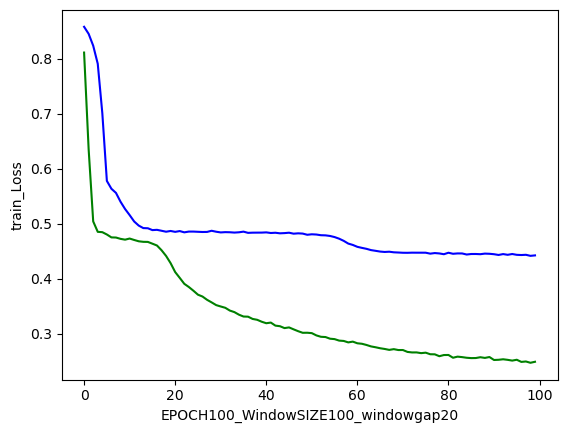

In [24]:
import matplotlib
import matplotlib.pyplot as plt
x=range(0,EPOCHS)
# plt.ylim((0, 1))
plt.plot(x,y1,label='recon_losses',color='green')
plt.plot(x,y2,label='forecast_losses',color='blue')
plt.xlabel(f'EPOCH{EPOCHS}_WindowSIZE{Window}_windowgap{Window_gap}')
plt.ylabel('train_Loss')
plt.savefig(f'EPOCH{EPOCHS}_WindowSIZE{Window}_MSL_train_contrastive.png')
plt.show()

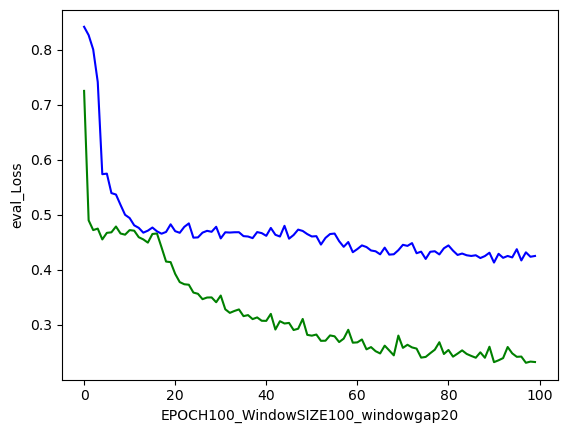

In [39]:
import matplotlib
import matplotlib.pyplot as plt
x=range(0,EPOCHS)
plt.plot(x,y3,label='recon_losses',color='green')
plt.plot(x,y4,label='forecast_losses',color='blue')
plt.xlabel(f'EPOCH{EPOCHS}_WindowSIZE{Window}_windowgap{Window_gap}')
plt.ylabel('eval_Loss')
plt.savefig(f'EPOCH{EPOCHS}_WindowSIZE{Window}_MSL_eval_contrastive.png')
plt.show()

In [26]:
best_model = MTAD_GAT(n_features = number_features, window_size = Window, out_dim = number_features, feat_gat_embed_dim = 256, time_gat_embed_dim = 64)
best_model=torch.nn.DataParallel(best_model,device_ids=[0,1]).cuda() 
best_model.load_state_dict( torch.load( os.path.join( 'model_checkpoints', str(Best_Epoch) + '.pt' ) )['Model'] )
# best_model.to(device1)
# model = model.to(device1)  # 将模型移动到第一个GPU设备上
# model = DataParallel(model, device_ids=[0, 1])  # 将模型封装为DataParallel模型，并指定使用两个GPU设备

<All keys matched successfully>

In [27]:
# mydata_test= pd.read_csv('/kaggle/input/train-test/test.csv')
# # mydata_test= pd.read_csv('/kaggle/input/abnormal-data/abnormal_test.csv')
# mydata_test = np.array(mydata_test)
# mydata_test = mydata_test[:,0:9]
# mydata_test.shape

# smap_data_test = []
# for smap_channel in smap_channels:
#     tmp_data = np.load(os.path.join('data/test/', smap_channel + '.npy'))
#     smap_data_test.extend(tmp_data)  
# smap_data_test = np.array(smap_data_test)
# print("Shape of Test DataSet : ", smap_data_test.shape)

# mydata_test= pd.read_csv('/kaggle/input/train-test/test.csv')
mydata_test= pd.read_csv('/kaggle/input/msl-data/msl_test.csv')

mydata_test = np.array(mydata_test)
mydata_test = mydata_test[:,0:27]
mydata_test.shape

(2049, 27)

In [28]:
my_data_test_norm, _ = normalize_data(mydata_test, scaler)
my_data_test_norm = mydata_test[:1000]
my_data_test_pt = torch.from_numpy(my_data_test_norm)
my_data_test_pt.size()

Data normalized


torch.Size([1000, 27])

In [29]:
my_test_x_y = SlidingWindowDataset(my_data_test_pt, Window)
test_dl = torch.utils.data.DataLoader(my_test_x_y, batch_size=256, shuffle=False)
print("Number of Batches in Test Dataloader : ", len(test_dl))

Number of Batches in Test Dataloader :  4


In [30]:
# smap_data_test = []
# for smap_channel in smap_channels:
#     tmp_data = np.load(os.path.join('/kaggle/input/smapdatatest/test', smap_channel + '.npy'))
#     smap_data_test.extend(tmp_data)
    
# smap_data_test = np.array(smap_data_test)
# print("Shape of Test DataSet : ", smap_data_test.shape)

In [31]:
# smap_data_test_norm, _ = normalize_data(smap_data_test, scaler)
# smap_data_test_norm = smap_data_test_norm[:1000]
# smap_data_test_pt = torch.from_numpy(smap_data_test_norm)
# smap_data_test_pt.size()

In [32]:
# smap_test_x_y = SlidingWindowDataset(smap_data_test_pt, Window)
# test_dl = torch.utils.data.DataLoader(smap_test_x_y, batch_size=256, shuffle=False)
# print("Number of Batches in Test Dataloader : ", len(test_dl))

In [33]:
model.eval()
preds = []
recons = []

with torch.no_grad():
    for batch in tqdm(test_dl):
        x = batch[0].to(device).float()
        y = batch[1].to(device).float()

        y_hat, _ ,y_hat_1, _1 = model(x)

        # Shifting input to include the observed value (y) when doing the reconstruction
        recon_x = torch.cat((x[:, 1:, :], y), dim=1)
        _, window_recon,_1, window_recon_1 = model(recon_x)

        preds.append(y_hat.detach().cpu().numpy())
        # Extract last reconstruction only
        recons.append(window_recon[:, -1, :].detach().cpu().numpy())
#         preds_1.append(y_hat_1.detach().cpu().numpy())
#         # Extract last reconstruction only
#         recons_1.append(window_recon_1[:, -1, :].detach().cpu().numpy())


    preds = np.concatenate(preds, axis=0)
    recons = np.concatenate(recons, axis=0)
#     preds_1 = np.concatenate(preds_1, axis=0)
#     recons_1 = np.concatenate(recons_1, axis=0)

  0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:775: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:956: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


In [34]:
preds.shape, recons.shape
scale_scores = True


In [35]:
preds_1.shape, recons_1.shape
scale_scores = True

In [36]:
# actual = smap_data_test_norm[Window:]
actual = my_data_test_norm[Window:]

print(actual.shape)

anomaly_scores = np.zeros_like(actual)
df = pd.DataFrame()
for i in range(preds.shape[1]):
    df[f"Forecast_{i}"] = preds[:, i]
    df[f"Recon_{i}"] = recons[:, i]
    df[f"True_{i}"] = actual[:, i]
    a_score = np.sqrt((preds[:, i] - actual[:, i]) ** 2) + np.sqrt(
        (recons[:, i] - actual[:, i]) ** 2)

    if scale_scores:
        q75, q25 = np.percentile(a_score, [75, 25])
        iqr = q75 - q25
        median = np.median(a_score)
        a_score = (a_score - median) / (1+iqr)

    anomaly_scores[:, i] = a_score
    df[f"A_Score_{i}"] = a_score

anomaly_scores = np.mean(anomaly_scores, 1)
df['A_Score_Global'] = anomaly_scores

(900, 27)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all

In [37]:
csv_data = df.to_csv(f'EPOCH{EPOCHS}_WindowSIZE{Window}_windowgap{Window_gap}_contrastive.csv', index = True)
df

,Forecast_0,Recon_0,True_0,A_Score_0,Forecast_1,Recon_1,True_1,A_Score_1,Forecast_2,Recon_2,...,A_Score_24,Forecast_25,Recon_25,True_25,A_Score_25,Forecast_26,Recon_26,True_26,A_Score_26,A_Score_Global
0,-0.965657,-1.015607,-1.0,-0.015588,0.974439,0.779439,0.999906,-0.373570,-0.841103,-0.929307,...,0.171058,-0.898499,-0.967349,-0.999133,0.015924,-0.806517,-0.790667,-1.000000,-0.091934,-0.069481
1,-0.960321,-1.015424,-1.0,-0.010713,0.996448,0.777897,1.464000,-0.082411,-0.820523,-0.927413,...,0.167199,-0.889103,-0.967252,-0.999133,0.024665,-0.794978,-0.789414,-1.000000,-0.083600,-0.041279
2,-0.983553,-1.014767,-1.0,-0.033310,1.141349,0.776387,1.704049,0.025591,-0.786817,-0.926302,...,0.172885,-0.909368,-0.967698,-0.999133,0.005594,-0.821488,-0.788095,-1.000000,-0.100012,0.022968
3,-1.008280,-1.015226,-1.0,-0.040602,1.258994,0.774640,1.702518,-0.012567,-0.770888,-0.926479,...,0.167805,-0.923789,-0.968064,-0.999133,-0.008022,-0.806698,-0.788822,-1.000000,-0.090850,0.014766
4,-1.002583,-1.015909,-1.0,-0.045344,1.238525,0.774462,1.700952,-0.006949,-0.773006,-0.927181,...,0.171153,-0.920454,-0.968131,-0.999133,-0.005013,-0.789377,-0.789622,-1.000000,-0.080087,-0.069669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,-0.943896,-1.024294,-1.0,0.013215,0.110521,0.732306,-0.953519,0.429587,-1.005333,-0.935478,...,0.013735,-0.891700,-0.973582,1.000000,3.453228,-0.042576,-0.811072,-1.000000,0.392476,0.274089
896,-0.944054,-1.024294,-1.0,0.013065,0.079356,0.731669,-0.955803,0.420852,-1.007311,-0.935843,...,-0.287280,-0.889603,-0.973534,1.000000,3.451254,0.018884,-0.810970,-1.000000,0.432583,0.180957
897,-0.949702,-1.023164,-1.0,0.006654,0.086554,0.734089,-0.958170,0.425455,-1.007681,-0.935833,...,-0.463282,-0.895732,-0.973362,1.000000,3.456739,0.005084,-0.809523,-0.130435,0.176346,0.173618
898,-0.967217,-1.022681,-1.0,-0.010371,0.039541,0.734854,-0.960561,0.412154,-1.031827,-0.936037,...,-0.452199,-0.905330,-0.973296,1.000000,3.465516,0.120462,-0.808148,-1.000000,0.500599,0.196042


In [38]:
# # actual = smap_data_test_norm[Window:]
# actual_1 = my_data_test_norm[Window:]

# print(actual_1.shape)

# anomaly_scores_1 = np.zeros_like(actual_1)
# df_1 = pd.DataFrame()
# for i in range(preds.shape[1]):
#     df_1[f"Forecast_{i}"] = preds_1[:, i]
#     df_1[f"Recon_{i}"] = recons_1[:, i]
#     df_1[f"True_{i}"] = actual_1[:, i]
#     a_score = np.sqrt((preds_1[:, i] - actual_1[:, i]) ** 2) + np.sqrt(
#         (recons_1[:, i] - actual_1[:, i]) ** 2)

#     if scale_scores:
#         q75, q25 = np.percentile(a_score, [75, 25])
#         iqr = q75 - q25
#         median = np.median(a_score)
#         a_score = (a_score - median) / (1+iqr)

#     anomaly_scores[:, i] = a_score
#     df_1[f"A_Score_{i}"] = a_score

# anomaly_scores_1 = np.mean(anomaly_scores_1, 1)
# df_1['A_Score_Global'] = anomaly_scores_1